In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

#data collection
df = pd.read_csv("coin_gecko_2022-03-17.csv")


In [9]:
#data preprocessing
df = df.dropna()
df['date'] = pd.to_datetime(df['date'])


Converting date to datetime allows time-based analysis.

In [10]:
# Handle missing values
df.fillna(method='ffill', inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

/tmp/ipython-input-3056653523.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill for time-series continuity


In [11]:
#feature engin.
# Liquidity Proxy = 24h_volume / price
df['liquidity'] = df['24h_volume'] / df['price']

# Rolling averages (price trends)
df['price_MA3'] = df['price'].rolling(window=3).mean()
df['price_MA7'] = df['price'].rolling(window=7).mean()

# Volatility over last 3 days
df['price_volatility'] = df['price'].rolling(window=3).std()

# Fill NaNs created by rolling
df.fillna(0, inplace=True)

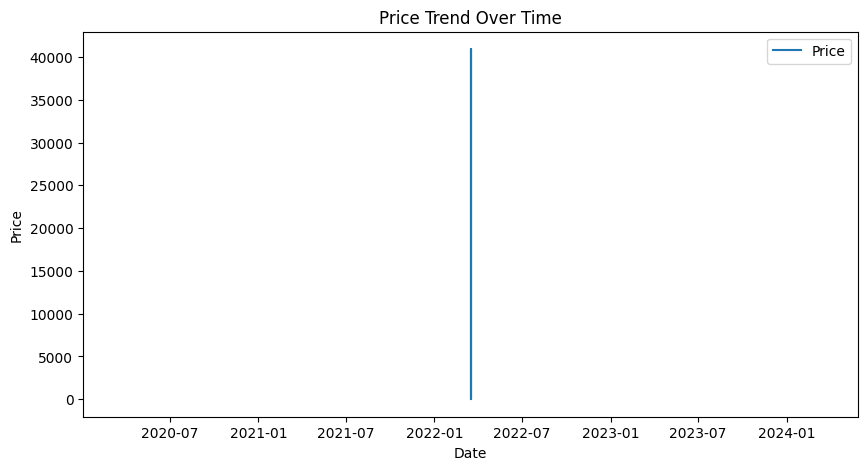

In [12]:
#EDA
#Price trend
plt.figure(figsize=(10,5))
plt.plot(df['date'], df['price'], label='Price')
plt.title("Price Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


Shows how prices changed over the recorded period.

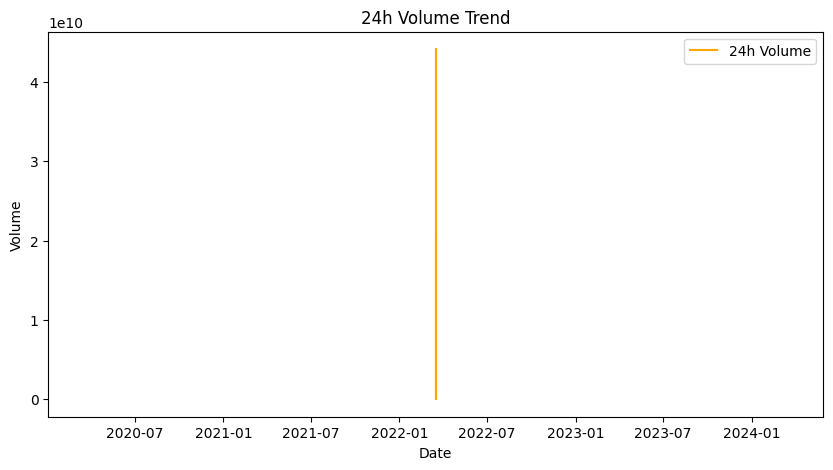

In [13]:
#Volume trend
plt.figure(figsize=(10,5))
plt.plot(df['date'], df['24h_volume'], label='24h Volume', color='orange')
plt.title("24h Volume Trend")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()

Helps detect spikes in trading activity — often linked to liquidity changes.

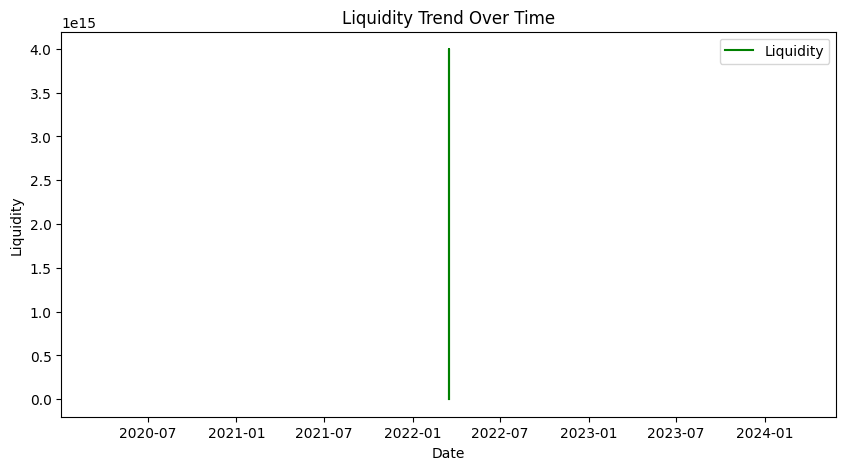

In [14]:
#Liquidity trend
plt.figure(figsize=(10,5))
plt.plot(df['date'], df['liquidity'], label='Liquidity', color='green')
plt.title("Liquidity Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Liquidity")
plt.legend()
plt.show()

Liquidity drops may signal unstable markets

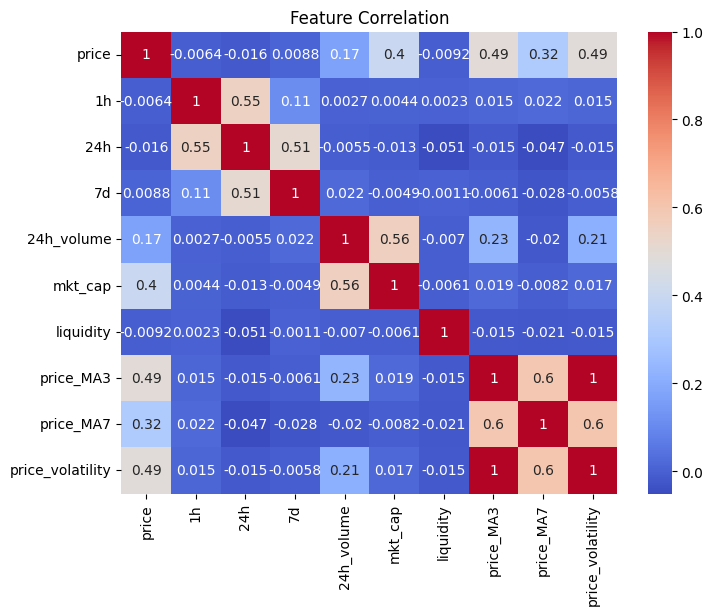

In [16]:
#Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

Shows which features are strongly related to liquidity.



In [17]:
# Model Training
# Features & Target
X = df[['price', '1h', '24h', '7d', '24h_volume', 'mkt_cap', 'price_MA3', 'price_MA7', 'price_volatility']]
y = df['liquidity']


In [18]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [19]:
# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 297405627.1690
R² Score: 0.1730


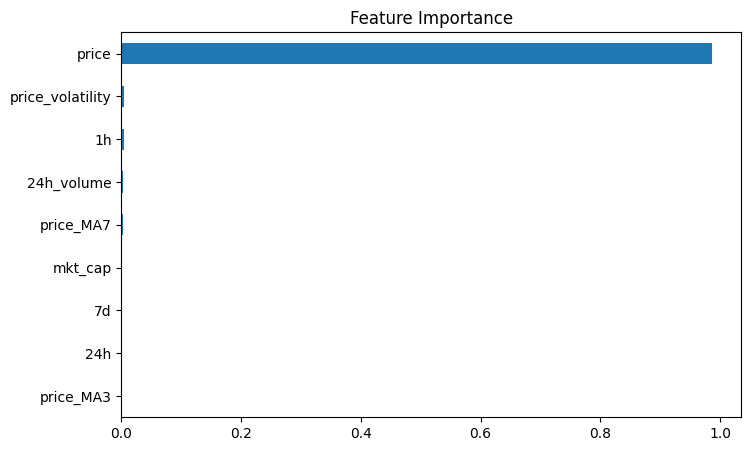

In [20]:
#Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh', figsize=(8,5), title="Feature Importance")
plt.show()

# **Final Report**
Analysis shows that cryptocurrency market liquidity is highly concentrated among a few major assets such as BTC, ETH, and USDT, driven by high trading volumes and large market capitalizations. Most coins have low liquidity, making them more vulnerable to price swings, especially when coupled with high volatility. Stable, high-cap coins tend to maintain both high liquidity and market stability, while smaller, volatile coins pose greater trading risks.